In [1]:
import json
import hashlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tikzplotlib
import seaborn as sns
from PIL import Image
from tqdm import tqdm

plt.rc('text', usetex=True)
plt.rc('font', family='serif')

pd.options.mode.chained_assignment = None

## Parse DeepFashion `.txt` category labels to pandas dataframes

In [2]:
data_prefix = '../data/DeepFashion/'

category_names_file = data_prefix + 'anno/list_category_cloth.txt'
category_labels_file = data_prefix + 'anno/list_category_img.txt'

attribute_names_file = data_prefix + 'anno/list_attr_cloth.txt'
attribute_labels_file = data_prefix + 'anno/list_attr_img.txt'

In [3]:
def read_tuple_format(txt_path):
    with open(txt_path, 'rt') as f:
        num_entries = int(f.readline())
        column_1, column_2 = f.readline().rstrip().split()
        cat_splits = [l.rstrip().split() for l in f]
        data_dict = {column_1: [' '.join(split[:-1]).rstrip() for split in cat_splits], 
                     column_2: [split[-1] for split in cat_splits]}
        assert(len(cat_splits) == num_entries)
        df = pd.DataFrame.from_dict(data_dict)
        return df

In [4]:
category_names = read_tuple_format(category_names_file)
category_names.category_type = category_names.category_type.apply(int)
category_names.head()

,category_name,category_type
0,Anorak,1
1,Blazer,1
2,Blouse,1
3,Bomber,1
4,Button-Down,1


In [5]:
category_labels = read_tuple_format(category_labels_file)
category_labels = category_labels.set_index('image_name')
category_labels.category_label = category_labels.category_label.apply(int)
category_labels.category_label -= 1
category_labels.head()

,category_label
image_name,
img/Sheer_Pleated-Front_Blouse/img_00000001.jpg,2
img/Sheer_Pleated-Front_Blouse/img_00000002.jpg,2
img/Sheer_Pleated-Front_Blouse/img_00000003.jpg,2
img/Sheer_Pleated-Front_Blouse/img_00000004.jpg,2
img/Sheer_Pleated-Front_Blouse/img_00000005.jpg,2


## Parse DeepFashion `.txt` attribute labels to python dict

In [6]:
def read_vector_format(txt_path):
    data_dict = {}
    with open(txt_path, 'rt') as f:
        num_entries = int(f.readline())
        index_name, vector_column = f.readline().rstrip().split()
        for line in tqdm(f, total=num_entries):
            line_split = line.rstrip().split()
            dense_vec = np.array([int(x) for x in line_split[1:]])
            sparse_indices = np.argwhere(dense_vec != -1).flatten().tolist()
            data_dict[line_split[0]] = sparse_indices
        assert(len(data_dict) == num_entries)
        return data_dict        

In [7]:
attribute_names = read_tuple_format(attribute_names_file)
attribute_names.attribute_type = attribute_names.attribute_type.apply(int)
attribute_names.head()

,attribute_name,attribute_type
0,a-line,3
1,abstract,1
2,abstract chevron,1
3,abstract chevron print,1
4,abstract diamond,1


In [8]:
attribute_labels = read_vector_format(attribute_labels_file)
next(iter(attribute_labels.items()))

100%|██████████| 289222/289222 [01:10<00:00, 4115.38it/s]


('img/Sheer_Pleated-Front_Blouse/img_00000001.jpg', [717, 818])

## Read test-train split partitions

In [9]:
test_train_split = read_tuple_format('../data/DeepFashion/eval/list_eval_partition.txt')
test_train_split = test_train_split.set_index('image_name')
test_train_split.to_csv(data_prefix + '/eval_processed/eval_partition.tsv', sep='\t')

## Filter out examples without texture labels

In [10]:
texture_names = attribute_names[attribute_names.attribute_type == 1]
texture_ids = set(texture_names.index)
texture_labels = {img: [attr for attr in attrs if attr in texture_ids]
                  for img, attrs in attribute_labels.items()
                  if len(set(attrs).intersection(texture_ids)) > 0}

In [11]:
len(category_labels)

289222

In [12]:
category_labels.join(test_train_split).evaluation_status.value_counts()

train    209222
val       40000
test      40000
Name: evaluation_status, dtype: int64

In [13]:
len(texture_labels)

111405

In [14]:
pd.DataFrame(texture_labels.keys()).set_index(0).join(test_train_split).evaluation_status.value_counts()

train    80522
val      15538
test     15345
Name: evaluation_status, dtype: int64

## Filter out duplicate images

In [15]:
from imagededup.methods import PHash

def remove_duplicates(data_prefix, image_names):  
    phasher = PHash()
    hashed_images = dict()
    unique_images = set()
    for img in tqdm(image_names):
        img_hash = phasher.encode_image(data_prefix + img)
        hashed_images.setdefault(img_hash, []).append(img)
    for phash, imgs in hashed_images.items():
        unique_images.add(imgs[0])
    return unique_images

In [16]:
unique_images = remove_duplicates(data_prefix, category_labels.index.values)
unique_category_labels = category_labels[category_labels.index.isin(unique_images)]
unique_texture_labels = {img: attrs for img, attrs in texture_labels.items() if img in unique_images}

100%|██████████| 289222/289222 [07:17<00:00, 660.80it/s]


In [17]:
len(unique_category_labels)

279057

In [18]:
len(unique_texture_labels)

106649

In [19]:
unique_category_labels.join(test_train_split).evaluation_status.value_counts()

train    201908
test      38620
val       38529
Name: evaluation_status, dtype: int64

In [20]:
pd.DataFrame(unique_texture_labels.keys()).set_index(0).join(test_train_split).evaluation_status.value_counts()

train    77059
val      14835
test     14755
Name: evaluation_status, dtype: int64

In [21]:
unique_category_labels = unique_category_labels[unique_category_labels.index.isin(unique_texture_labels)]

## Remap category and texture label ids

In [22]:
relevant_category_ids = unique_category_labels.category_label.unique()
relevant_category_names = category_names[category_names.index.isin(relevant_category_ids)]
len(relevant_category_names)

46

In [23]:
relevant_texture_ids = set(tex_id for textures in unique_texture_labels.values() for tex_id in textures)
relevant_texture_names = texture_names[texture_names.index.isin(relevant_texture_ids)]
len(relevant_texture_names)

156

In [24]:
relevant_category_names['new_id'] = range(len(relevant_category_names))
relevant_texture_names['new_id'] = range(len(relevant_texture_names))

In [25]:
remapped_category_labels = unique_category_labels.category_label.apply(lambda cat_id: relevant_category_names.loc[cat_id].new_id)
remapped_category_labels = pd.DataFrame(remapped_category_labels)

In [26]:
remapped_texture_labels = {img: [int(relevant_texture_names.loc[tex_id].new_id) for tex_id in textures]
                           for img, textures in tqdm(unique_texture_labels.items())}

100%|██████████| 106649/106649 [00:20<00:00, 5186.72it/s]


In [27]:
relevant_category_names = relevant_category_names.set_index('new_id')
relevant_texture_names = relevant_texture_names.set_index('new_id')

In [28]:
unique_category_labels.join(test_train_split).evaluation_status.value_counts()

train    77059
val      14835
test     14755
Name: evaluation_status, dtype: int64

In [29]:
len(unique_texture_labels)

106649

## Validate label → image mapping

In [30]:
def plot_image_samples(category_labels, category_names, texture_labels, texture_names, n_rows, n_cols):
    num_articles = n_rows * n_cols

    fig, axes = plt.subplots(n_rows, n_cols)
    fig.set_figheight(n_rows * 5)
    fig.set_figwidth(n_cols * 4)
    fig.suptitle(f'{num_articles} random article images from the DeepFashion dataset and their associated category label', fontsize=18, y=0.92)

    for idx, (image_name, category_label_row) in enumerate(category_labels.sample(num_articles).iterrows()):
        row_idx = idx // n_cols
        col_idx = idx % n_cols
        img = np.array(Image.open(data_prefix + image_name.replace('img/', 'img_resized/')))
        tex_ids = texture_labels[image_name]
        tex_names = '\n'.join([texture_names.loc[int(i)].attribute_name for i in tex_ids])
        axes[row_idx, col_idx].imshow(img)
        axes[row_idx, col_idx].set_title('\huge{' + category_names.loc[category_label_row.category_label].category_name + '}\n' + tex_names)

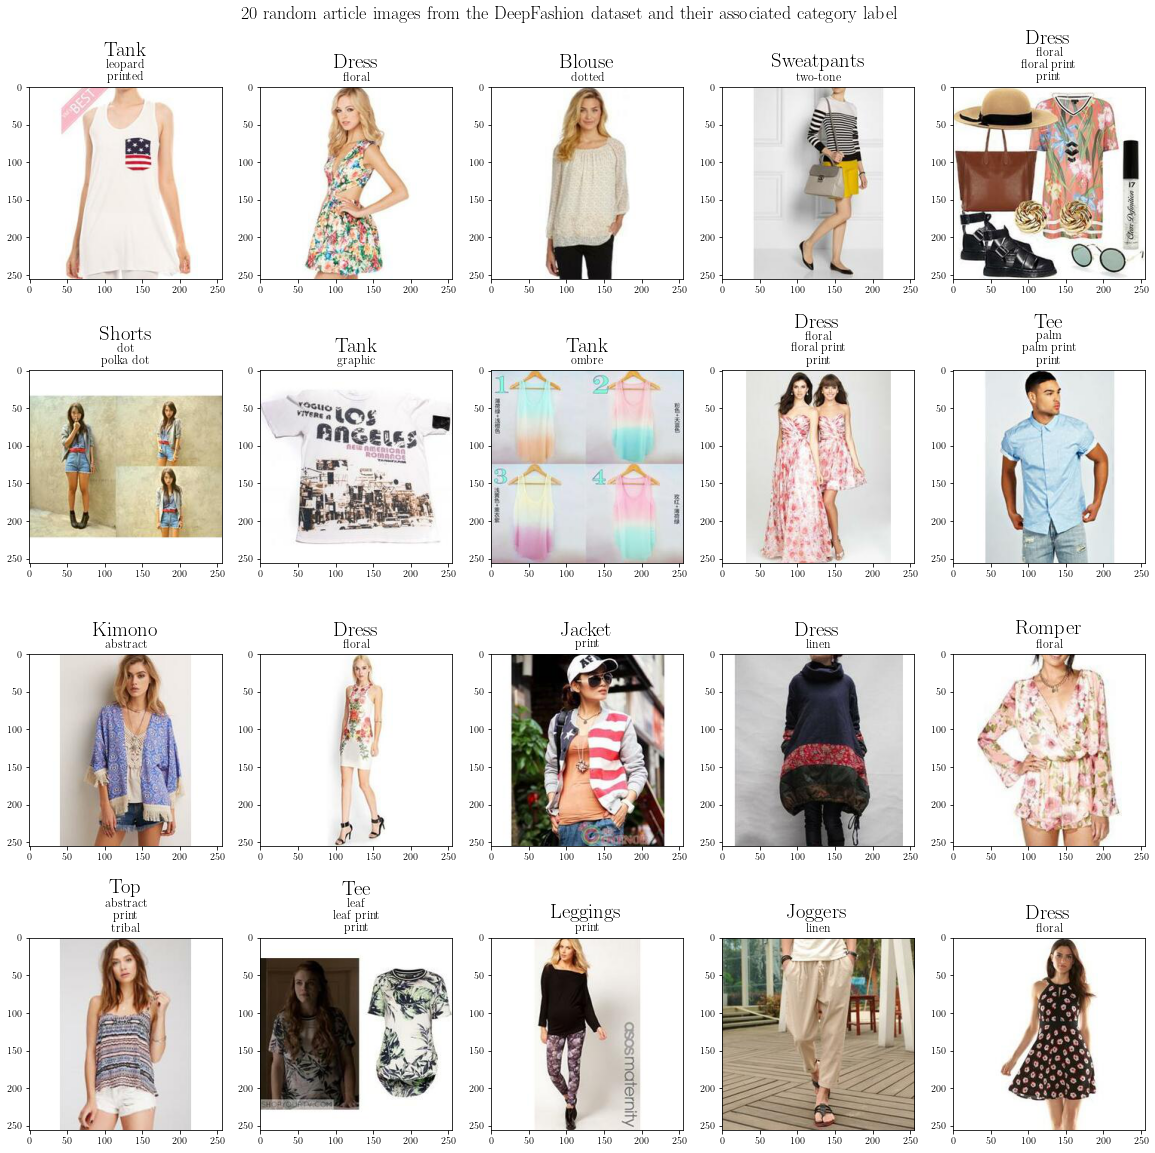

In [31]:
plot_image_samples(remapped_category_labels, relevant_category_names, remapped_texture_labels, relevant_texture_names, 4, 5)

## Save processed category labels as `.tsv` format

In [32]:
relevant_category_names.to_csv(data_prefix + 'anno_processed/category_names.tsv', index=False, sep='\t')
remapped_category_labels.to_csv(data_prefix + 'anno_processed/category_labels.tsv', sep='\t')

## Save processed texture labels as `.jsonl` format

In [33]:
def save_vector_dict(vec_dict, path):
    dims = len(next(iter(vec_dict.values())))
    with open(path, 'wt') as f:
        for image_name, attributes in tqdm(vec_dict.items()):
            row = {'image_name': image_name, 'textures': attributes}
            f.write(json.dumps(row) + '\n')

In [34]:
relevant_texture_names.to_csv(data_prefix + 'anno_processed/texture_names.tsv', index=False, sep='\t')
save_vector_dict(remapped_texture_labels, data_prefix + 'anno_processed/texture_labels.jsonl')

100%|██████████| 106649/106649 [00:00<00:00, 259323.99it/s]


## Analyze category labels

In [35]:
plt.style.use('seaborn')

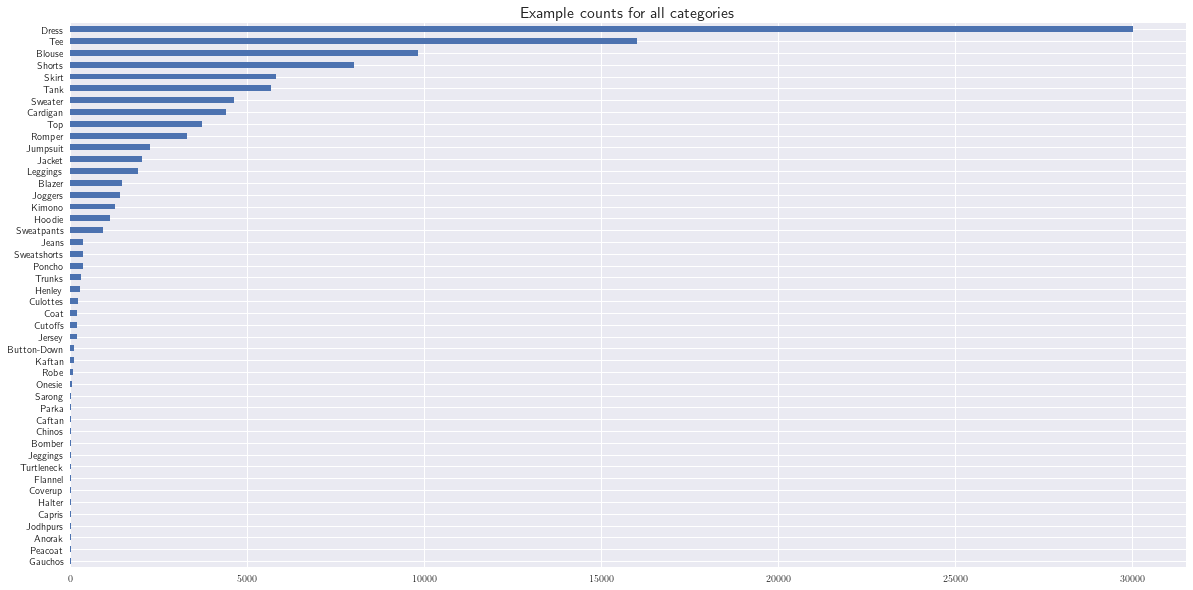

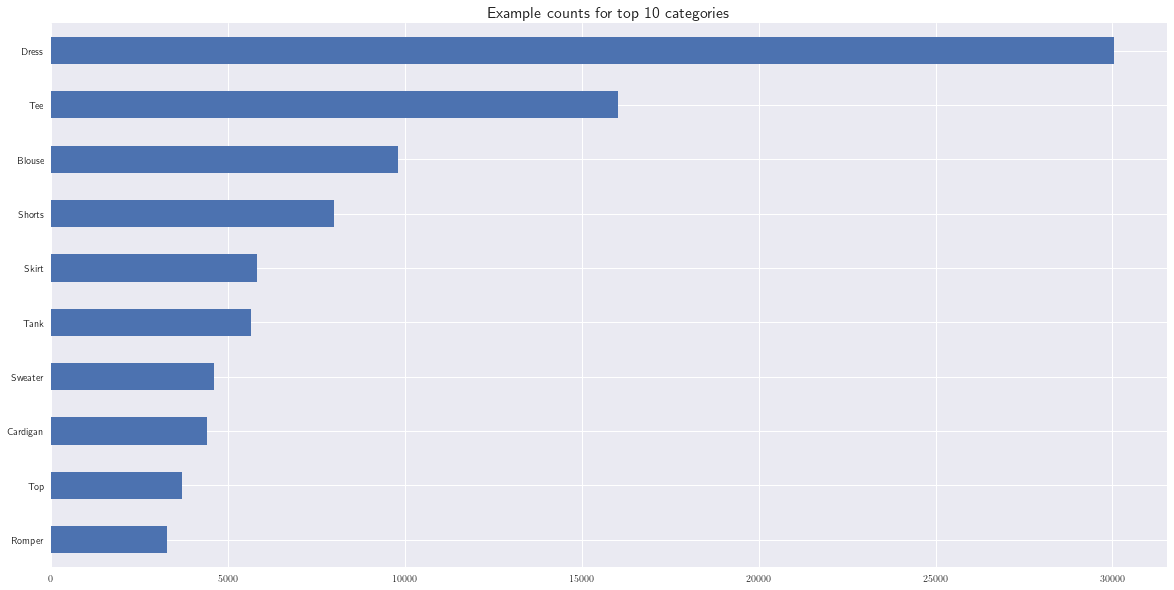

In [36]:
category_counts = remapped_category_labels.category_label.value_counts().sort_values()
category_counts.index = category_counts.index.map(lambda x: relevant_category_names.category_name[x])
ax = category_counts.plot.barh(figsize=(20,10))
ax.set_title('Example counts for all categories', fontsize=16)
plt.show()

ax = category_counts[-10:].plot.barh(figsize=(20,10))
ax.set_title('Example counts for top 10 categories', fontsize=16)
tikzplotlib.save('../results/figures/top10_categories.tex')

## Analyze texture labels

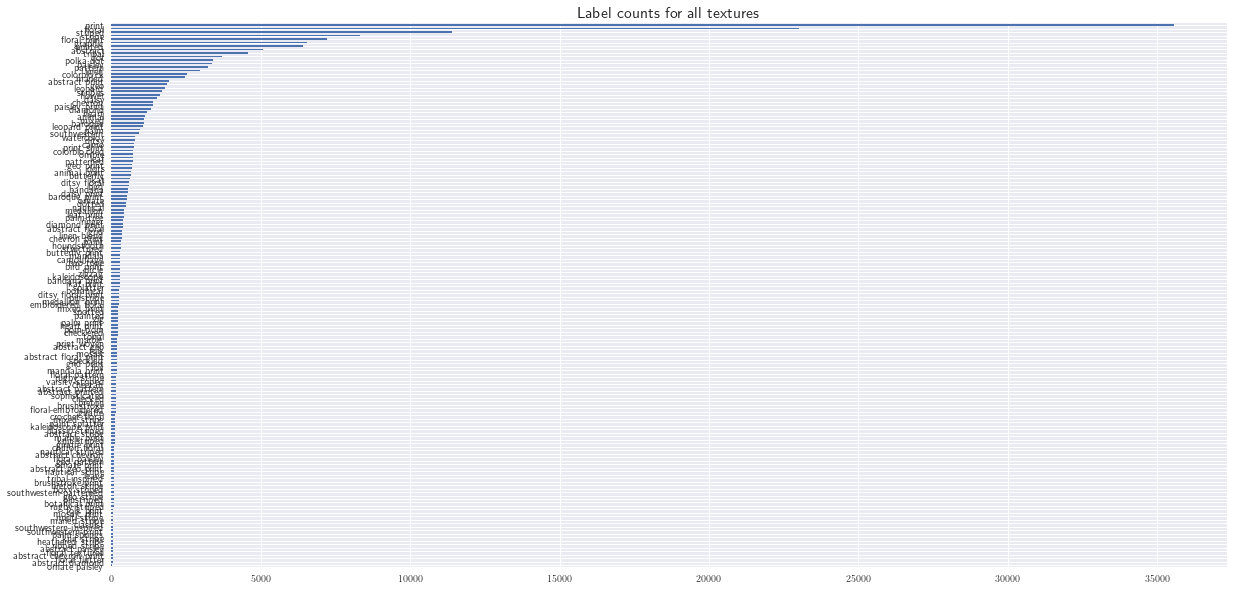

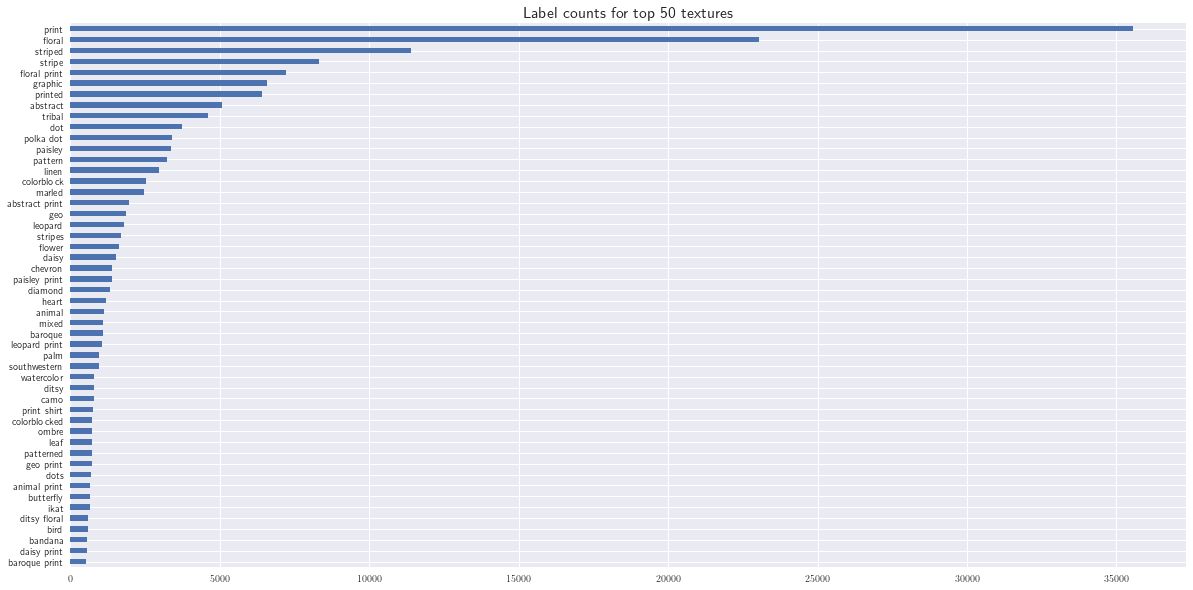

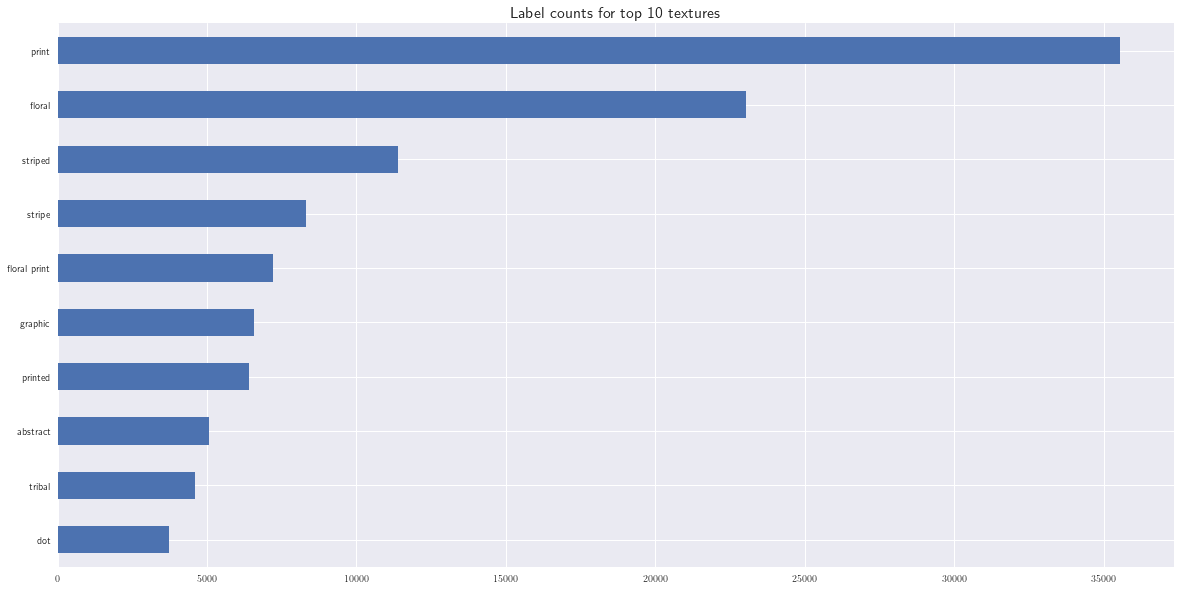

In [37]:
texture_counts = pd.Series([val for vals in remapped_texture_labels.values() for val in vals]).value_counts().sort_values()
texture_counts.index = texture_counts.index.map(lambda x: relevant_texture_names.attribute_name[x])
ax = texture_counts.plot.barh(figsize=(20,10))
ax.set_title('Label counts for all textures', fontsize=16)
plt.show()

ax = texture_counts[-50:].plot.barh(figsize=(20,10))
ax.set_title('Label counts for top 50 textures', fontsize=16)
plt.show()

ax = texture_counts[-10:].plot.barh(figsize=(20,10))
ax.set_title('Label counts for top 10 textures', fontsize=16)
tikzplotlib.save('../results/figures/top10_textures.tex')